## Bike Sharing Demand

#### Kaggle 競賽連結 https://www.kaggle.com/c/bike-sharing-demand

### 名次 : 321 in 3251 ，約前10%

In [1]:
import os
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
print('Setup complete')

Setup complete


In [2]:
!ls ..

config	input  lib  working


In [3]:
!pwd

/kaggle/working


In [4]:
os.getcwd()

'/kaggle/working'

In [5]:
os.listdir('.')

['__notebook_source__.ipynb', '.ipynb_checkpoints']

In [6]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submit = pd.read_csv('../input/sampleSubmission.csv')
print('Read Complete')

Read Complete


In [7]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.info() #info() 看資料有沒有空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [9]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


In [11]:
train.describe()
# 這裡的count 是 label，其他columns是 feature

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Feature Engineering
### 大略看資料分布

In [12]:
# 對每個column來判斷最大值是否是離群值
train_describe = train.describe()
train_describe.head()
train_describe.loc['max'] > (train_describe.loc['mean']+3*train_describe.loc['std'])


season        False
holiday        True
workingday    False
weather        True
temp          False
atemp         False
humidity      False
windspeed      True
casual         True
registered     True
count          True
dtype: bool

In [13]:
#remove outlier(以count 來計算，移除超過平均值3倍sigma的rows)
# 這裡做的是，把label值中，明顯偏差過大的值除去，避免對Model造成影響
print('Shape of the Before Outliers:',train.shape)
train = train[np.abs(train['count']-train['count'].mean())<=(3*train['count'].std())]
print('Shape of the After Outliers:',train.shape)

Shape of the Before Outliers: (10886, 12)
Shape of the After Outliers: (10739, 12)


### 初步資料處理

In [14]:
# 先把Train, Test Data合併後一起處理時間部分，將其數字化為可以丟進Model的形式
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis='columns')
data.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


In [15]:
# 將時間處理成讓Random forest可以分析的格式

data['date'] = data.datetime.apply(lambda x : x.split()[0])
data['hour'] = data.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')
data['year'] = data.datetime.apply(lambda x : x.split()[0].split('-')[0])
data['weekday'] = data.date.apply(lambda dataString : datetime.strptime(dataString, "%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0,2011-01-01,0,2011,5,1
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0,2011-01-01,1,2011,5,1
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0,2011-01-01,2,2011,5,1
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0,2011-01-01,3,2011,5,1
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0,2011-01-01,4,2011,5,1


### 觀察Feature，並針對有問題的資料作調整
#### ● Feature 的資料型態可以簡分成 numerical variables 和 categorical variables
#### ● 這邊針對 numerical variables 作圖，觀察資料趨勢

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


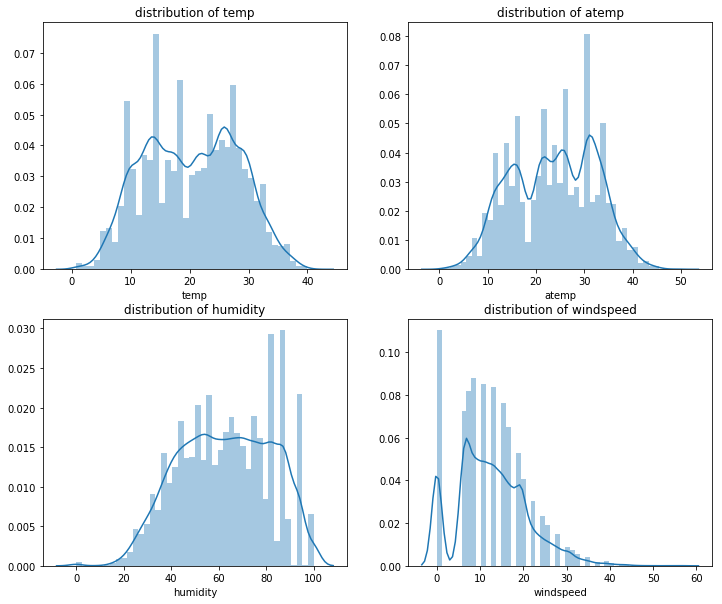

In [16]:

fig, axes = plt.subplots(2,2)
fig.set_size_inches(12, 10)
sns.distplot(data['temp'], ax=axes[0][0])
sns.distplot(data['atemp'], ax=axes[0][1])
sns.distplot(data['humidity'], ax=axes[1][0])
sns.distplot(data['windspeed'], ax=axes[1][1])

axes[0][0].set(xlabel='temp', title='distribution of temp')
axes[0][1].set(xlabel='atemp',title="distribution of atemp")
axes[1][0].set(xlabel='humidity',title="distribution of humidity")
axes[1][1].set(xlabel='windspeed',title="distribution of windspeed")
# axes[1][1].set(xlim=(0,10),xlabel='windspeed',title="distribution of windspeed")
fig.show()
#這邊觀察到風速為0的值異常的多，風速2~5則沒有值(資料不連續)，推測可能太小的值機器量測不到，系統會認定為0

In [17]:
#我們先將資料分成風速為0以及風速不為0的資料，並且用風速不為0的資料來訓練random forest的模型，將訓練好的模型來預估風速為0的風速到底是多少。
dataWind0 = data[data.windspeed==0]
dataWindNot0 = data[data.windspeed!=0]

rfModel_wind = RandomForestRegressor(n_estimators=1000, random_state=42)
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0.windspeed)

wind0Values = rfModel_wind.predict(dataWind0[windColumns])
dataWind0.loc[:,'windspeed'] = wind0Values

data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.head(15)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,12.880,0.0,1.0,2011-01-01 05:00:00,0,75,1.0,1,9.84,2,6.0032,0,2011-01-01,5,2011,5,1
1,19.695,12.0,36.0,2011-01-01 10:00:00,0,76,24.0,1,15.58,1,16.9979,0,2011-01-01,10,2011,5,1
2,16.665,26.0,56.0,2011-01-01 11:00:00,0,81,30.0,1,14.76,1,19.0012,0,2011-01-01,11,2011,5,1
3,21.210,29.0,84.0,2011-01-01 12:00:00,0,77,55.0,1,17.22,1,19.0012,0,2011-01-01,12,2011,5,1
4,22.725,47.0,94.0,2011-01-01 13:00:00,0,72,47.0,1,18.86,2,19.9995,0,2011-01-01,13,2011,5,1
5,22.725,35.0,106.0,2011-01-01 14:00:00,0,72,71.0,1,18.86,2,19.0012,0,2011-01-01,14,2011,5,1
6,21.970,40.0,110.0,2011-01-01 15:00:00,0,77,70.0,1,18.04,2,19.9995,0,2011-01-01,15,2011,5,1
7,21.210,41.0,93.0,2011-01-01 16:00:00,0,82,52.0,1,17.22,2,19.9995,0,2011-01-01,16,2011,5,1
8,21.970,15.0,67.0,2011-01-01 17:00:00,0,82,52.0,1,18.04,2,19.0012,0,2011-01-01,17,2011,5,1
9,21.210,9.0,35.0,2011-01-01 18:00:00,0,88,26.0,1,17.22,3,16.9979,0,2011-01-01,18,2011,5,1


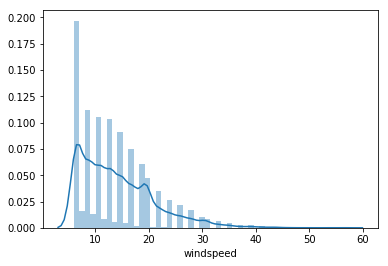

In [18]:
sns.distplot(data.windspeed)
#調整風速資料的結果如下

### 觀察Label，並調整

In [19]:
#先把data分解成原本的兩組資料，並刪除不需要的columns
dataTrain = data[~data['count'].isnull()].sort_values(by='datetime')
dataTest = data[data['count'].isnull()].sort_values(by='datetime')
datetimecol = dataTest["datetime"]

yLabels = dataTrain["count"]
dropFeatures = ['casual',"count","datetime","date","registered"]
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)
dataTrain.head(15)

,atemp,holiday,humidity,season,temp,weather,windspeed,workingday,hour,year,weekday,month
15068,14.395,0,81,1,9.84,1,6.999983,0,0,2011,5,1
15069,13.635,0,80,1,9.02,1,6.747321,0,1,2011,5,1
15070,13.635,0,80,1,9.02,1,6.747321,0,2,2011,5,1
15071,14.395,0,75,1,9.84,1,6.688371,0,3,2011,5,1
15072,14.395,0,75,1,9.84,1,6.688371,0,4,2011,5,1
0,12.880,0,75,1,9.84,2,6.003200,0,5,2011,5,1
15073,13.635,0,80,1,9.02,1,6.747321,0,6,2011,5,1
15074,12.880,0,86,1,8.20,1,6.779684,0,7,2011,5,1
15075,14.395,0,75,1,9.84,1,6.688371,0,8,2011,5,1
15076,17.425,0,76,1,13.12,1,9.124935,0,9,2011,5,1


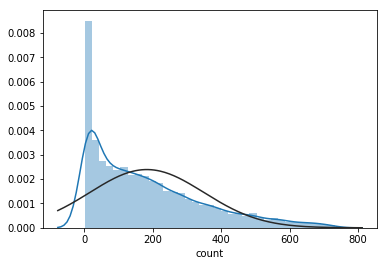

In [26]:
from scipy.stats import * #要先import，才能使用下面fit 參數的功能
sns.distplot(yLabels, fit=norm)
#由觀察可發現，Lable資料皆集中在左側，也就是count < 300 出現的機率較高，也就是實際使用者行為的結果約落在<300 (這裡300只是約略抓的值)
# 所以在train model前，可以藉由inhance 次數低(左側)的資料，來把model 訓練得更好

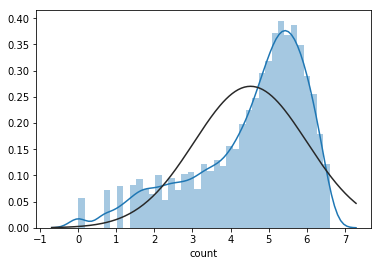

In [23]:
yLabelLog = np.log(yLabels)
sns.distplot(yLabelLog, fit=norm)

## Modeling and Prediction (uning RandomForestRegressor)

In [28]:
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
rfModel.fit(dataTrain, yLabelLog) #這裡取過log的Label去train model
rf_predsLog = rfModel.predict(dataTest)

## Modeling and Prediction (using GradientBoostingRegressor)

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

gbModel = GradientBoostingRegressor(n_estimators=1000, random_state=42)
gbModel.fit(dataTrain, yLabelLog) #這裡取過log的Label去train model
gb_predsLog = gbModel.predict(dataTest)

### magic method: ensemble

In [31]:
# predsLog = np.mean([rf_predsLog, gb_predsLog],0) # magic method: ensemble
predsLog = 0.3*rf_predsLog + 0.7*gb_predsLog # magic method: ensemble

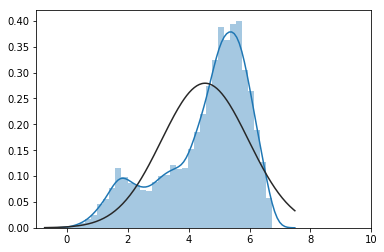

In [32]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_xlim(-1,10)
sns.distplot(predsLog, fit=norm)

6493


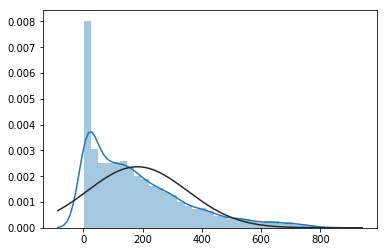

In [33]:
#prediction結果取反log回來
preds = np.exp(predsLog)
print(preds.size)
sns.distplot(preds, fit=norm)

In [ ]:
# predsTest = gbModel.predict(X= dataTest)
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in preds]
    })
submission.to_csv('bike_predictions_RF.csv', index=False)
print('finish')

### Modeling and Prediction (using original Labels(lable without taking log))

In [ ]:
# rfModel = RandomForestRegressor(n_estimators=1000, random_state=77)
# rfModel.fit(dataTrain, yLabels)
# preds = rfModel.predict(dataTest)

# sns.distplot(preds, fit=norm)

In [ ]:
# predsTest = rfModel.predict(X= dataTest)
# submission = pd.DataFrame({
#         "datetime": datetimecol,
#         "count": [max(0, x) for x in preds]
#     })
# submission.to_csv('bike_predictions_RF.csv', index=False)
# print('finish')